In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **RFM Segmentation**

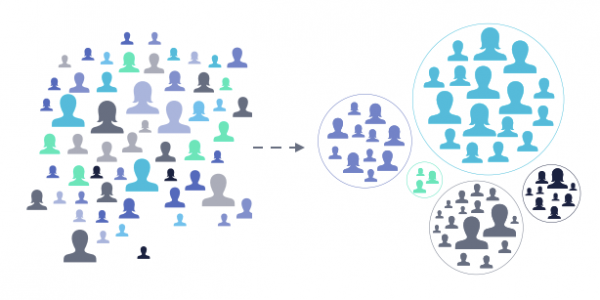

 Customer Segmentation is a practice of dividing a company's customers into groups that reflects the similarity among customers in each group. It can be done based on their needs, interests, priorities, by geography,etc.


With our dataset we are proceeding with RFM Segmentation.

# **Loading Packages**

We are loading the necessary packages for our code.

In [ ]:
import numpy as np
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install openpyxl

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

# **Reading the data**
We are reading the excel file.

In [ ]:
df=pd.read_excel("../input/online-retail-ii-data-set-from-ml-repository/online_retail_II.xlsx")

# **Checking the data**

To know more about our dataset, we are running few lines of code to check the **dimensions** of our dataset, **data types** of the variables and **basic infomation** about the variables.

In [ ]:
df.shape

In [ ]:
df.dtypes

In [ ]:
df.describe()

When we look into the features Quantity and Price,

* We can see the negative values, which indicates returned product
* Also, comparing the 75% and the max values, we can clearly see the presence of outliers in the data.

In [ ]:
df.head()

### **Finding unique values**

In [ ]:
print('A total of '+ str(df.Invoice.nunique()) +' unique invoices were generated.')

In [ ]:
print('We have '+ str(df.StockCode.nunique()) +' unique products sold online.')


In [ ]:
# We are renaming the CustomerID for our conveniency
df = df.rename(columns={'Customer ID':'CustomerID'})

print('We have '+ str(df.CustomerID.nunique()) +' unique Customers in our dataset.')

In [ ]:
print('We have customers spread across '+ str(df.Country.nunique()) +' countries. ')

## **Data Preprocessing**


### **Null Value Check**

In [ ]:
df.isnull().sum().sort_values(ascending=False)

We have a lot of customers without Customer ID.

### **Corelation Check**

In [ ]:
corrDf = df.corr()
sns.heatmap(corrDf, 
        xticklabels=corrDf.columns,
        yticklabels=corrDf.columns, cmap='coolwarm_r')

The variables are not corelated with each other.

### **Dropping negative values**

We are dropping rows which has negative quantity and price. 

In [ ]:
df = df[(df['Quantity']>0) & (df['Price']>0)] 
df.describe()

In [ ]:
df.shape

### **Removing duplicates**

We are removing duplicated data from our dataset.

In [ ]:
df=df.drop_duplicates()
df.shape

## **RFM Analysis**

The first step in building an RFM model is to assign Recency, Frequency and Monetary values to each customer. So, RFM analysis can be carried out only on customers who have customerID.

**RFM Metrics**

**Recency**  : It is the amount of time since the customers most recent transaction. It is measured                 in days.
 
**Frequency**: Total number of transactions made by the customer.
 
**Monetary** : Total amount the customer has spent across all transactions.

To calculate the Recency value, we need to find the last invoice date in our dataset.

In [ ]:
df.InvoiceDate.max()

In [ ]:
# Create a column Amount(Total cost)
df['Amount'] = df['Quantity'] * df['Price']

In [ ]:
pin_date = dt.datetime(2010, 12,10)

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (pin_date - InvoiceDate.max()).days,
                                     'Invoice': lambda Invoice: Invoice.nunique(),
                                     'Amount': lambda Amount: Amount.sum()})

rfm.head()

### Changing the column names

In [ ]:
rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm[rfm["monetary"] > 0]
rfm.head()

### **Calculate the score**

We need to assign a score from 1 to 5 to recency, frequency and monetary value individually for each customer.

Below is the **conversion** of columns into rfm scores between 1 to 5. 

**'5'** being the **highest** and **'1'** being the **least**.

- The higher the **monetary** value, higher is the score ie,'5' . 


- Smaller value of **recency** indicates recent purchases, so it takes the higher value of 5. 


- Frequency is the same as monetary, higher the **frequency**, higher the score.

In [ ]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])


rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm['score']=rfm['recency_score'].astype(int)+rfm['frequency_score'].astype(int)+rfm['monetary_score'].astype(int)

In [ ]:
rfm.head()

### Best customers

With the help of score, we will be able to identify the best customers in our e-commerce company.

In [ ]:
rfm[rfm['score']== 15].sort_values('monetary', ascending=False).head()

The customers having a score of '15' are considered as the 'best customers' as they have have the highest recency, frequency and monetary score.

They are asset to the company.

### **Number of best customers** 

In [ ]:
rfm[rfm['score']==15].count()

There are 349 Best customers in the company who are frequent buyers and also generate high revenue.

## **Seggregate the levels**

We are going to **seggregate** the level of the customer **based on the score**.

Here we have classified them into **4 levels**.

**Active** : High revenue generating and frequent buyers .

**Good**: Customers whose purchases are fairly frequent and generate moderate revenue.

**Average** : Customers who are less active and are not very frequent buyers and generate low revenue.

**Inactive**: Customers generating very low revenue and are occasional buyers.

In [ ]:
def rfm_level(score):
    if  ((score >1) and (score < 4)):
        return 'Inactive'
    elif ((score >3) and (score < 8)):
        return 'Average'
    elif ((score > 7) and (score <11)):
        return 'Good'
    else:
        return 'Active'

In [ ]:
rfm['level'] = rfm['score'].apply(lambda score : rfm_level(score))
rfm.head()

### Visualising number of customers for each level

In [ ]:
plt.figure(figsize=(10,5))
sns.set_context("poster", font_scale=0.7)
sns.set_palette('twilight')
sns.countplot(rfm['level'])

From the above bar graph, we can infer that
* There are only few Inactive customers in the online retail store when compared to the other levels.
* It is good to notice that there are more number of Active customers.

### Analysing each level

To understand each segment of customers better, we are going to deep dive on each segment. 

In [ ]:
rfm.groupby('level').agg({
    'recency' : ['mean', 'min','max'],
    'frequency' : ['mean', 'min','max'],
    'monetary' : ['mean','min','max','count']
})

### Active Customers

We can say that 1597 customers bought 4540.46 units by shopping 9 times approximately every 26 days.

They are previliged customers.


Surprise offers can be given on birthdays and anniversary.

### Good Customers

1079 customers have bought 939.92 units by shopping thrice every 70 days

They are loyal customers.

### Average customers

1434 customers have bought approximately 939.92 units by shopping once every 151 days.

Tiered pricing of products can be introduced.

### Inactive customers

202 customers have bought approximately 142.49 units by shopping once every 273 days.


Personalised emails and SMS can be sent to the customers regarding the offers.

More marketing strategies can be introduced to improve the frequency of orders.


### Visualizing against each of the factors 

In [ ]:
cross_table1 = pd.crosstab(index=rfm['monetary_score'], columns=rfm['frequency_score'])
cross_table2 = pd.crosstab(index=rfm['monetary_score'], columns=rfm['recency_score'])
cross_table3 = pd.crosstab(index=rfm['frequency_score'], columns=rfm['recency_score'])
plt.figure(figsize=(20,30))
plt.subplot(311)
ax1 = sns.heatmap(cross_table1, cmap='viridis', annot=True, fmt=".0f")
ax1.invert_yaxis()
ax1.set_ylabel('Monetary')
ax1.set_xlabel('Frequency')
ax1.set_title('Monetary vs Frequency')
plt.subplot(312)
ax2 = sns.heatmap(cross_table2, cmap='viridis', annot=True, fmt=".0f")
ax2.invert_yaxis()
ax2.set_ylabel('Monetary')
ax2.set_xlabel('Recency')
ax2.set_title('Monetary vs Recency')
plt.subplot(313)
ax3 = sns.heatmap(cross_table3, cmap='viridis', annot=True, fmt=".0f")
ax3.invert_yaxis()
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Recency')
ax3.set_title('Recency vs Frequency')
plt.show()

### Segmenting customers based on their levels

In [ ]:
active = rfm[rfm['level'] == 'Active']
average = rfm[rfm['level'] == 'Average']
good = rfm[rfm['level'] == 'Good']
inactive = rfm[rfm['level'] == 'Inactive']

### Saving in separate excel file

 We are saving the customers in separate files, so that it will be easy for the company to send relevent offers and messages to group of customers who belong to the same segment

In [ ]:
active_df = pd.DataFrame()
active_df["customer_id"] = rfm[rfm["level"] == "Active"].index

active_df.to_excel("active_customers.xlsx", sheet_name='Active Customers Index')

In [ ]:
average_df = pd.DataFrame()
average_df["customer_id"] = rfm[rfm["level"] == "Average"].index

average_df.to_excel("average_customers.xlsx", sheet_name='Average Customers Index')

In [ ]:
good_df = pd.DataFrame()
good_df["customer_id"] = rfm[rfm["level"] == "Good"].index

good_df.to_excel("good_customers.xlsx", sheet_name='Good Customers Index')

In [ ]:
inactive_df = pd.DataFrame()
inactive_df["customer_id"] = rfm[rfm["level"] == "Inactive"].index

inactive_df.to_excel("inactive_customers.xlsx", sheet_name='Inactive Customers Index')

## RFM Clustering

We are going to apply **unsupervised machine learning** to identify different groups/clusters based on segmentation of customers according to their purchasing behaviour.


The overall clusters will be based on the 3 factors - **recency, frequency and monetary values**

#### Looking at the RFM data


In [ ]:
rfm.describe()

There is **no negative** value in the dataset.

#### Checking outliers

#### Outlier treatment for recency


In [ ]:
plt.boxplot(rfm.recency)
Q1 = rfm.recency.quantile(0.25)
Q3 = rfm.recency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.recency >= Q1 - 1.5*IQR) & (rfm.recency <= Q3 + 1.5*IQR)]

#### Outlier treatment for frequency

In [ ]:
plt.boxplot(rfm.frequency)
Q1 = rfm.frequency.quantile(0.25)
Q3 = rfm.frequency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.frequency >= Q1 - 1.5*IQR) & (rfm.frequency <= Q3 + 1.5*IQR)]

##### Outlier treatment for monetary

In [ ]:
plt.boxplot(rfm.monetary)
Q1 = rfm.monetary.quantile(0.25)
Q3 = rfm.monetary.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.monetary >= (Q1 - 1.5*IQR)) & (rfm.monetary <= (Q3 + 1.5*IQR))]

## K Means

### Transforming the data

In [ ]:
rfm1=rfm[['recency','frequency','monetary']]
scaler = StandardScaler()
x_scaled=scaler.fit(rfm1)
x_scaled = scaler.fit_transform(rfm1)
x_scaled

#### Elbow method

We are going to **determine the number of clusters** using Elbow method.

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(x_scaled)  
visualizer.show()   

According to the Elbow method, the number of clusters is **3**.

### Applying K-Means

In [ ]:
kmeans_scaled = KMeans(3)
kmeans_scaled.fit(x_scaled)
identified_clusters = kmeans_scaled.fit_predict(rfm1)
clusters_scaled = rfm1.copy()
clusters_scaled['cluster_pred']=kmeans_scaled.fit_predict(x_scaled)
print(identified_clusters)
sns.set(style="darkgrid")
print(" Our cluster centers are as follows")
print(kmeans_scaled.cluster_centers_)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()

### Visualizing the clusters

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=clusters_scaled['recency']
yline=clusters_scaled['frequency']
zline=clusters_scaled['monetary']

ax.scatter3D(xline, zline,yline,c=clusters_scaled['cluster_pred'])
ax.view_init(30, 60)

### Validation

We will use Silhoutte score to validate our clusters.

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
sil_score = silhouette_score(x_scaled, kmeans_scaled.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % sil_score)

from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(3)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(x_scaled)   
visualizer.poof()   
   

### Cluster Profiling

We are going to analyse and understand our clusters.

In [ ]:
rfm1['cluster']= clusters_scaled['cluster_pred']
rfm1['level']=rfm['level']

rfm1.groupby('cluster').agg({
    'recency' : ['mean','min','max'],
    'frequency' : ['mean','min','max'],
    'monetary' : ['mean','min','max','count']
})

 From the above summary we get to know that,
    
- **Cluster 0** is the most valuable group of customers with **highest mean frequency** (purchase most often), **least mean recency** (has recently purchased from the company) and the **highest mean monetary** (high purchasing amount).
    
    
- On the other hand, **Cluster 2** is the group of customers with **least frequency** and **monetary** and **recency values**.


In [ ]:
rfm1.head()

### Nature of the cluster

We need to check whether the predicted clusters are **homogeneous** or **heterogeneous** in nature.

In [ ]:
rfm1.groupby(['cluster','level']).size()

### Observations

**Cluster 1** is **heterogenous** in nature. It comprises **Active, Average and Good customers**.

**Cluster 0** is **homogeneous** in nature and has **Active customers** in majority.
 

### Comparing RFM analysis and Clusters

**Transforming** and storing the RFM values for plotting a snake plot.

In [ ]:
rfm_scaled=pd.DataFrame()
rfm_scaled=rfm1.copy()
scaler=StandardScaler()
rfm_scaled[['recency', 'frequency','monetary']] = scaler.fit_transform(rfm_scaled[['recency', 'frequency','monetary']])
rfm_scaled['cust_id']=rfm1.index

In [ ]:
rfm_scaled.head()

#### Melting the dataframe

In [ ]:
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['cust_id', 'level', 'cluster'], var_name = 'metrics', value_name = 'value')
rfm_melted.head()

### Snake plot based on RFM segmentation

In [ ]:
sns.lineplot(x = 'metrics', y = 'value', hue = 'level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')


### Snake plot with clusters using K-Means

In [ ]:
sns.lineplot(x = 'metrics', y = 'value', hue = 'cluster', data = rfm_melted)
plt.title('Snake Plot of Clusters')
plt.legend(loc = 'upper right')

## Conclusion

We made two kinds of segmentation, RFM quantiles and K-Means clustering methods.

Customers have been categorized into 4 buckets based on Recency, Frequency and Monetary value of their purchases. Targeted strategy to be applied for each customer segment.

With the result,

* We figured out ‘best’ customers, the most profitable group.
* This also tells us on which customer group we should focus on and to whom to give special offers or promotions among the customers.
* We can select the best communication channel for each segment and improve new marketing strategies.

 A big **Thank You** to all the Data Science aspirants across the globe who have shared their work in Kaggle. This has enhanced my coding skills and improved my understanding of Data Science concepts. I have used few excerpts of code in the above excercise as well.

